In [1]:
from torchinfo import summary

In [2]:
import torch
import torch.nn as nn


class Inception(nn.Module):
    def __init__(
        self,
        in_planes,
        kernel_1_x,
        kernel_3_in,
        kernel_3_x,
        kernel_5_in,
        kernel_5_x,
        pool_planes,
    ):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


model = GoogLeNet()
summary(model, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [1, 10]                   --
├─Sequential: 1-1                        [1, 192, 32, 32]          --
│    └─Conv2d: 2-1                       [1, 192, 32, 32]          5,376
│    └─BatchNorm2d: 2-2                  [1, 192, 32, 32]          384
│    └─ReLU: 2-3                         [1, 192, 32, 32]          --
├─Inception: 1-2                         [1, 256, 32, 32]          --
│    └─Sequential: 2-4                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           12,352
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    └─Sequential: 2-5                   [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-4                  [1, 96, 32, 32]           18,528
│    │    └─BatchNorm2d: 3-5             [1, 96, 32, 32]           192
│

In [9]:
from torchvision import models
from torchinfo import summary

vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

print(summary(vgg19, (1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

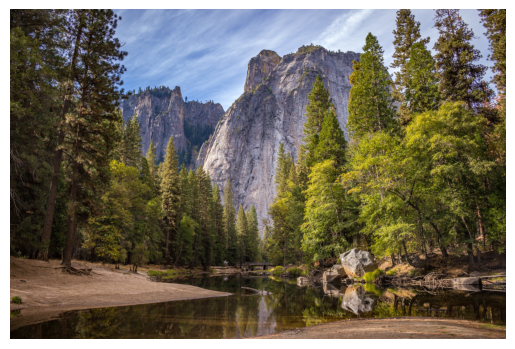

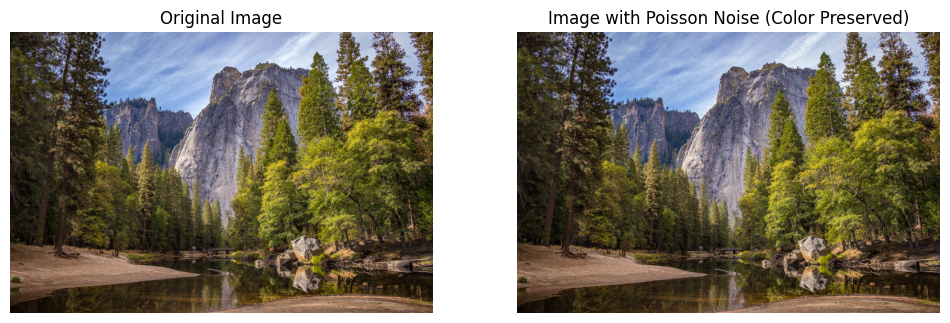

In [6]:
import torchvision.transforms.v2 as transforms
import cv2
import matplotlib.pyplot as plt

# --- 1. 이미지 로드 및 전처리 ---
img = cv2.imread("./DIV2K_0007.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose(
    [
        transforms.ToImage(),  # HWC -> CHW
        transforms.ToDtype(torch.float32, scale=True),  # 0-255 uint8 -> 0-1 float32
    ]
)

img_float = transform(img_rgb)

# --- 2. 원본 색상을 유지하는 포아송 노이즈 추가 ---

# 노이즈의 강도를 조절하는 파라미터 (작을수록 노이즈가 강해짐)
# 이 값을 조절하여 노이즈 레벨을 제어할 수 있습니다.
alpha = 0.01

# 포아송 분포를 따르는 노이즈 생성
# 1. 원본 이미지(img_float)를 alpha로 나누어 포아송 분포의 'rate'를 구합니다.
# 2. torch.poisson을 적용해 rate에 해당하는 포아송 분포에서 값을 샘플링합니다.
# 3. 샘플링된 값에서 다시 rate(img_float / alpha)를 빼주어 노이즈의 평균을 0으로 만듭니다.
# 4. 마지막으로 alpha를 곱해 노이즈의 스케일을 다시 맞춰줍니다.
noise = alpha * (torch.poisson(img_float / alpha) - (img_float / alpha))

# 원본 이미지에 노이즈를 더합니다.
degraded = img_float + noise

# gaussian_noise = transforms.GaussianNoise(sigma=0.1)
# degraded = gaussian_noise(img_float)

# --- 3. 시각화를 위한 후처리 ---

# 노이즈가 더해지면서 픽셀 값이 [0, 1] 범위를 벗어날 수 있으므로 클램핑(clamping)해줍니다.
degraded = torch.clamp(degraded, 0, 1)

# 시각화를 위해 텐서를 다시 numpy 배열로 변환
degraded_np = degraded.permute(1, 2, 0).numpy()

# --- 4. 원본과 노이즈 이미지 비교 시각화 ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(degraded_np)
plt.title("Image with Poisson Noise (Color Preserved)")
plt.axis("off")

plt.show()

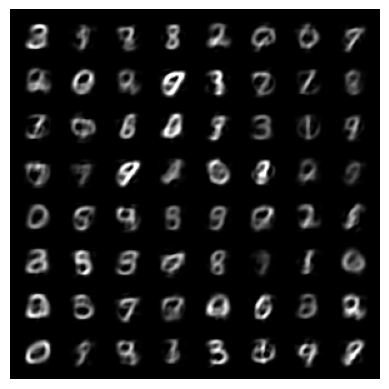

In [2]:
from core.config import DiffusionConfig
from core.optimizer import AdamWParams
from core.pipeline import DiffusionPipeline


config = DiffusionConfig(
    name="vae_mnist",
    model="vae",
    dataset="mnist",
    batch_size=128,
    shuffle=True,
    optimizer="adam",
    optimizer_params=AdamWParams(lr=3e-4),
    loss_function="vae_loss",
    early_stopping=True,
    early_stopping_monitor="train_loss",
    early_stopping_min_delta=-0.002,
    early_stopping_min_delta_strategy="previous_proportional",
    epochs=100,
    save_after_n_epoch=True,
    save_after_n_epoch_period=10,
)
pipeline = DiffusionPipeline(config)
pipeline.evaluate()

In [1]:
import torch
import torch.nn as nn
from einops import rearrange

# 가정: batch=2, heads=4, head_dim=32, h=14, w=14
b, heads, c = 2, 4, 32
h, w = 14, 14
qkv_channels = 3 * heads * c  # 384

# QKV 합쳐진 텐서
qkv = torch.randn(b, qkv_channels, h, w)
print(f"초기 qkv shape: {qkv.shape}")  # (2, 384, 14, 14)

# rearrange로 Q, K, V 분리
q, k, v = rearrange(
    qkv, "b (qkv heads c) h w -> qkv b heads c (h w)", heads=heads, qkv=3
)

print(f"\nQ shape: {q.shape}")  # (2, 4, 32, 196)
print(f"K shape: {k.shape}")  # (2, 4, 32, 196)
print(f"V shape: {v.shape}")  # (2, 4, 32, 196)

초기 qkv shape: torch.Size([2, 384, 14, 14])

Q shape: torch.Size([2, 4, 32, 196])
K shape: torch.Size([2, 4, 32, 196])
V shape: torch.Size([2, 4, 32, 196])


In [6]:
qkv_conv = nn.Conv2d(qkv_channels, qkv_channels, 1, 1, 0)(qkv)
print(qkv.shape, qkv_conv.shape)

torch.Size([2, 384, 14, 14]) torch.Size([2, 384, 14, 14])


In [2]:
b, c, h, w = 3, 64, 32, 32
q = torch.randn(b, c, h, w)
k = torch.randn(b, c, h, w)

print(q.shape, k.shape)

q = rearrange(q, "b c h w -> b (h w) c")
k = rearrange(k, "b c h w -> b c (h w)")

print(q.shape, k.shape)

o = torch.bmm(q, k)

print(o.shape)

torch.Size([3, 64, 32, 32]) torch.Size([3, 64, 32, 32])
torch.Size([3, 1024, 64]) torch.Size([3, 64, 1024])
torch.Size([3, 1024, 1024])
